In [29]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
np.set_printoptions(suppress=True)

## Load all the Dataset Data

In [30]:
import os
import json

PRE_PROCESS_DATA_FOLDER = "pre_processed_data"

In [31]:
def infer_column_type(column:pd.Series):
    try:
        column = pd.to_numeric(column)
    except:
        print("Failed cast to a numeric type.")
    if column[0] == "False":
        
         False
    elif column[0] == "True":
        column = True
    column = column.astype(str)
    return column


In [32]:
data_list = []

for file in os.listdir(PRE_PROCESS_DATA_FOLDER):
    if ".json" not in file:
        continue
    with open(os.path.join(PRE_PROCESS_DATA_FOLDER, file), "r") as f:
        load_data = json.load(f)
    data_list.append(pd.Series(list(load_data.values()), index=load_data.keys()))

In [33]:
data = pd.DataFrame(data_list)

In [34]:
data

,worker_id,worker_age,worker_lang,worker_fluency,set_name,set_trials,participant_type,platform_type,vision,target_error,...,trial_9_total_fix_points_p_filtered,pre_question_9_name,pre_question_9_time,question_9_name,question_9_time,question_9_answer,question_9_correct_flag,question_9_target_to_fixation_ratio,set_language,fixation_error
0,A10BH9PYCYUKDJ,42,English,5,mturk_EN_v01,"[meco_para_3, a_ScottishParliament_2, a_Rhine_...",None,None,None,False,...,457,q_before_a_VictoriaAustralia_2_qa_0,6849.0,q_after_a_VictoriaAustralia_2_qa_0,4544.0,car,1.0,0.006565,EN,False
1,A10C60VRCFZGDD,57,English,5,mturk_ES_v07,"[meco_para_12, a_Rhine_0, a_Steamengine_0, a_F...",None,None,None,False,...,0,q_before_a_Apolloprogram_4_qa_1,1348.0,q_after_a_Apolloprogram_4_qa_1,3815.0,idk,0.0,0.000000,ES,True
2,A10W3EILX06DFO,35,English,5,mturk_EN_v20,"[meco_para_11, a_Steamengine_0, a_Oxygen_1, a_...",None,None,None,False,...,152,q_before_a_SkyUnitedKingdom_4_qa_2,6584.0,q_after_a_SkyUnitedKingdom_4_qa_2,17068.0,virgin media,1.0,0.006579,EN,False
3,A11C5FSSHQEQ3E,38,English,5,mturk_EN_v13,"[meco_para_12, a_DoctorWho_4, a_VictoriaAustra...",None,None,None,False,...,53,q_before_a_FresnoCalifornia_0_qa_0,1376.0,q_after_a_FresnoCalifornia_0_qa_0,12718.0,southwest Fresno,1.0,0.000000,EN,False
4,A11EZAV2HRYKD5,27,English,4,mturk_DE_v04,"[meco_para_12, a_NikolaTesla_1, a_Universityof...",None,None,None,False,...,262,q_before_a_Steamengine_0_qa_1,11302.0,q_after_a_Steamengine_0_qa_1,6177.0,idk,0.0,0.015267,DE,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600,p6-volunteer-cognition,22,Croatian,4,mturk_EN_v18_cognition_volunteer,"[meco_para_11, a_SuperBowl50_3, a_FrenchandInd...",volunteer,cognition,None,False,...,2,q_before_a_SkyUnitedKingdom_1_qa_0,3097.0,q_after_a_SkyUnitedKingdom_1_qa_0,4073.0,1998,1.0,0.000000,EN,False
601,p7-lab-control,28,Spanish,4,mturk_EN_v02_lab_cognition,"[meco_para_3, a_Computationalcomplexitytheory_...",lab,cognition,normal,False,...,27,q_before_a_DoctorWho_3_qa_0,10387.0,q_after_a_DoctorWho_3_qa_0,4690.0,dudley simpson,1.0,0.148148,EN,False
602,p7-volunteer-cognition,22,Croatian,3,mturk_EN_v02_volunteer_cognition,"[meco_para_3, a_Computationalcomplexitytheory_...",volunteer,cognition,None,False,...,5,q_before_a_DoctorWho_3_qa_0,8174.0,q_after_a_DoctorWho_3_qa_0,8135.0,Dudley Simpson,1.0,0.400000,EN,False
603,p7-volunteer-cognition,23,Croatian,2,mturk_EN_v18_cognition_volunteer,"[meco_para_11, a_SuperBowl50_3, a_FrenchandInd...",volunteer,cognition,None,False,...,136,q_before_a_SkyUnitedKingdom_1_qa_0,3957.0,q_after_a_SkyUnitedKingdom_1_qa_0,4092.0,1998,1.0,0.022059,EN,False


In [35]:
# Filters to apply:
approved_only = (data.approved_flag > 0).to_numpy() 
no_fixation_error = (data.fixation_error == False).to_numpy()
no_target_error = (data.target_error == False).to_numpy()
sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
acc_higher = (data.avg_roi_last_val > 0).to_numpy()
filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
filter_sets = np.array([True if set_lang in ["EN", "DE", "ES", "TR"] else False for set_lang in data["set_language"]])
# Set a maximum time to 60 minutes
# "EN", "DE", "ES", "TR"
max_time_min = 60
filter_max_time = (data.exp_total_time < max_time_min/0.000016666).to_numpy()

screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720

In [36]:
dict_filter = {
    #"filter_mturks" : filter_mturks,
    "filter_sets" : filter_sets,
    #"Approved":approved_only,
    "Sample Rate": sample_higher_10,
    "Fix_Error, Target_Error": no_fixation_error & no_target_error,
    "screen_above_1280_720": screen_above_1280_720,
    "acc_thresh": acc_higher,
    f"Maximum time ({max_time_min} min)":filter_max_time
}

In [37]:
n_total = len(data)
current_filter = np.ones(len(data),dtype=bool)
for condition, f in dict_filter.items():
    n_data_filtered = len(data.iloc[~f & current_filter])
    per_cent = n_data_filtered/n_total * 100
    print(f"For condition ({condition}), {per_cent:.2f}% has been filtered. ({n_data_filtered} out of {n_total})")
    current_filter = current_filter & f
    n_total = len(data.iloc[current_filter])

For condition (filter_sets), 0.83% has been filtered. (5 out of 605)
For condition (Sample Rate), 12.50% has been filtered. (75 out of 600)
For condition (Fix_Error, Target_Error), 4.76% has been filtered. (25 out of 525)
For condition (screen_above_1280_720), 0.40% has been filtered. (2 out of 500)
For condition (acc_thresh), 1.41% has been filtered. (7 out of 498)
For condition (Maximum time (60 min)), 0.81% has been filtered. (4 out of 491)


In [38]:
# Combine filters into a mask
mask = np.ones(data.shape[0], dtype=bool)
for filter_name, filter_mask in dict_filter.items():
    mask = mask & filter_mask

In [39]:
data_filtered = data[mask].copy()
print("Before: ", data.shape, " After: ", data_filtered.shape)

Before:  (605, 197)  After:  (487, 197)


In [40]:
data_filtered[data_filtered.set_language=="EN"].worker_lang.value_counts()

English               150
Croatian               18
Chinese (Mandarin)      4
Portuguese              2
Greek                   2
Indonesian              1
Marathi                 1
Swahili                 1
Afrikaans               1
Bulgarian               1
Italian                 1
Spanish                 1
Name: worker_lang, dtype: int64

In [41]:
data_filtered[data_filtered.set_language=="DE"].worker_lang.value_counts()

English       28
German        15
Croatian       1
Portuguese     1
Name: worker_lang, dtype: int64

In [42]:
data_filtered[data_filtered.set_language=="ES"].worker_lang.value_counts()

Spanish               46
English               32
French                 2
Ukrainian              1
Estonian               1
Chinese (Mandarin)     1
Urdu                   1
Italian                1
Name: worker_lang, dtype: int64

In [43]:
# Load the text settings:
text_settings_all_settings = pd.read_csv("text_token_stats.csv", index_col=0)

In [44]:
data_filtered["question_0_name"]

0       meco_para_3_qa_0
2      meco_para_11_qa_1
4      meco_para_12_qa_1
5      meco_para_12_qa_0
6       meco_para_3_qa_3
             ...        
600    meco_para_11_qa_2
601     meco_para_3_qa_0
602     meco_para_3_qa_0
603    meco_para_11_qa_2
604     meco_para_3_qa_0
Name: question_0_name, Length: 487, dtype: object

In [45]:
USE_TEXT_FEATURES = False
TASK_NAME = "is"

In [46]:
# Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
data_for_cls_nr = []
data_for_cls_is = []
rows_dropped = 0
for i in range(10):
    for row_i, row in data_filtered.iterrows():
        # Remove rows where there is no fixation on text
        if row[f"trial_{i}_fixation_text_TRT"] == 0:
            assert row[f"trial_{i}_fixation_target_TRT"] == 0
            rows_dropped += 1
            continue
        set_lang = row["set_language"] 
        set_name = row["set_name"]
        worker_id = row["worker_id"]
        trial_name = row[f"trial_{i}_name"]
        target = row[f"question_{i}_name"]
        
        text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                        & (text_settings_all_settings["trial_name"] == trial_name)]
        word_sent_avg = text_features_row["sentence_count"].item()
        participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
        in_span_TRT = []
        out_span_TRT = []
        for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
            if type(fix_row["Span_word_is_in"]) is str:
                if target in fix_row["Span_word_is_in"]:
                    in_span_TRT.append(fix_row["TRT"])
            else:
                out_span_TRT.append(fix_row["TRT"])
        in_span_mean = np.nanmean(np.array(in_span_TRT))
        if np.isnan(in_span_mean):
            in_span_mean = 0
        out_span_mean = np.nanmean(np.array(out_span_TRT))
        if np.isnan(out_span_mean):
            out_span_mean = 0
        data_to_append = row[[
                f"trial_{i}_fixation_text_TRT", 
                f"trial_{i}_fixation_target_TRT", 
                f"trial_{i}_fixation_on_target", 
                f"question_{i}_target_to_fixation_ratio",
                f"trial_{i}_fixation_total",
                #f"trial_{i}_time",
                f"question_{i}_correct_flag"]].to_numpy()
        relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
        if USE_TEXT_FEATURES:
            data_to_append = np.hstack(( [
                                    in_span_mean,
                                    out_span_mean,
                                    relative_TRT,
                                    text_features_row["token_count"].item(),
                                    text_features_row["token_avg_length"].item(), 
                                      ], 
                                    data_to_append))
        else:
            data_to_append = np.hstack(( [
                                        in_span_mean,
                                        out_span_mean,
                                        relative_TRT,
                                        ], 
                                        data_to_append))
        # Trials < 5 are Normal Reading
        if i < 5:
            data_for_cls_nr.append(data_to_append)
        # Trials >= 5 are Information Seaking
        else:
            data_for_cls_is.append(data_to_append)
data_for_cls_nr = np.array(data_for_cls_nr)
data_for_cls_is = np.array(data_for_cls_is)

C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))


C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:33: RuntimeWarning: Mean of empty slice
  out_span_mean = np.nanmean(np.array(out_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: RuntimeWarning: Mean of empty slice
  in_span_mean = np.nanmean(np.array(in_span_TRT))
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\1663479321.py:30: 

In [47]:
rows_dropped, len(data_for_cls_is), len(data_for_cls_nr), len(data_for_cls_is)+len(data_for_cls_nr)

(22, 2413, 2435, 4848)

In [48]:
18/1940

0.009278350515463918

In [49]:
data_for_cls_is[:2].shape, data_for_cls_nr[:2].shape

((2, 9), (2, 9))

In [50]:
if TASK_NAME == "nr":
    data_for_classifier = np.array(data_for_cls_nr,dtype=float)
else:
    data_for_classifier = np.array(data_for_cls_is,dtype=float)

In [51]:
all_data = np.vstack((data_for_cls_is,data_for_cls_nr))

In [52]:
print("Information Seeking")
len(data_for_cls_is[data_for_cls_is[:,-1] == 1]), len(data_for_cls_is[data_for_cls_is[:,-1] == 0])

Information Seeking


(1590, 823)

In [53]:
data_for_cls_is[data_for_cls_is[:,-1] == 1][:,-2].mean()

120.9622641509434

In [54]:
data_for_cls_is[data_for_cls_is[:,-1] == 0][:,-2].mean()

142.11178614823817

In [55]:
print("Normal Reading")
len(data_for_cls_nr[data_for_cls_nr[:,-1] == 1]), len(data_for_cls_nr[data_for_cls_nr[:,-1] == 0])

Normal Reading


(1135, 1300)

In [56]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 1][:,-2].mean()

259.1876651982379

In [57]:
data_for_cls_nr[data_for_cls_nr[:,-1] == 0][:,-2].mean()

219.68615384615384

In [58]:
data_for_classifier

array([[  0.        , 530.97297297,   0.01823701, ...,   0.02240896,
        357.        ,   0.        ],
       [  0.        , 234.57142857,   0.0185788 , ...,   0.02052786,
        341.        ,   0.        ],
       [  0.        , 131.21428571,   0.02844477, ...,   0.03278689,
         61.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.43421053, ...,   0.4       ,
          5.        ,   1.        ],
       [  0.        , 209.31034483,   0.01500321, ...,   0.02205882,
        136.        ,   1.        ],
       [  0.        , 235.40740741,   0.01762538, ...,   0.01438849,
        139.        ,   1.        ]])

In [59]:
data_for_classifier[0]

array([    0.        ,   530.97297297,     0.01823701, 43812.        ,
         799.        ,     8.        ,     0.02240896,   357.        ,
           0.        ])

In [60]:
data_for_classifier[:,:-1]

array([[  0.        , 530.97297297,   0.01823701, ...,   8.        ,
          0.02240896, 357.        ],
       [  0.        , 234.57142857,   0.0185788 , ...,   7.        ,
          0.02052786, 341.        ],
       [  0.        , 131.21428571,   0.02844477, ...,   2.        ,
          0.03278689,  61.        ],
       ...,
       [  0.        ,   0.        ,   0.43421053, ...,   2.        ,
          0.4       ,   5.        ],
       [  0.        , 209.31034483,   0.01500321, ...,   3.        ,
          0.02205882, 136.        ],
       [  0.        , 235.40740741,   0.01762538, ...,   2.        ,
          0.01438849, 139.        ]])

In [61]:
X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]

In [62]:
X_train_unb, X_test_unb, y_train_unb, y_test_unb = train_test_split(X, y, test_size=0.2)

In [63]:
def upscale_dataset(X_train, y_train):
    minority_label = y_train[0]
    count_min_label = (y_train == minority_label).sum()
    for label in np.unique(y_train):
        n_examples = (y_train == label).sum()
        if n_examples < count_min_label:
            minority_label = label

    unbalance_n = (y_train!=minority_label).sum()-(y_train==minority_label).sum()
    indexes_to_add = np.random.choice(X_train[y_train==minority_label].shape[0], size=unbalance_n, replace=True)
    new_X_train = np.vstack((X_train, X_train[indexes_to_add,:]))
    new_y_train = np.hstack((y_train,np.zeros(unbalance_n)))
    balanced_dataset = np.hstack([new_X_train,new_y_train.reshape(-1,1)])
    np.random.shuffle(balanced_dataset)

    return balanced_dataset[:,:-1], balanced_dataset[:,-1]

In [64]:
#from imblearn.over_sampling import SMOTE

In [65]:
#sm = SMOTE()

In [66]:
X_train, y_train = upscale_dataset(X_train_unb, y_train_unb)

In [67]:
#clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
#clf = make_pipeline(StandardScaler(), LogisticRegression())
clf = RandomForestClassifier()
scores = cross_val_score(clf, X_train, y_train, cv=5)
scores

array([0.51593625, 0.50996016, 0.52788845, 0.51992032, 0.5059761 ])

In [68]:
scores.mean()

0.5159362549800797

In [69]:
clf.fit(X_train, y_train)
print("Acc Score: ", accuracy_score(y_test_unb, clf.predict(X_test_unb)), 
                    "F1-Score", f1_score(y_test_unb, clf.predict(X_test_unb), average="weighted"))

Acc Score:  0.5424430641821946 F1-Score 0.557831679075935


In [70]:
(y_test_unb==0).sum()

148

In [71]:
confusion_matrix(y_test_unb, clf.predict(X_test_unb))

array([[ 65,  83],
       [138, 197]], dtype=int64)

In [72]:
baseline = DummyClassifier()
baseline.fit(X_train_unb,y_train_unb)

DummyClassifier()

In [73]:
print("Acc Score: ", accuracy_score(y_test_unb, baseline.predict(X_test_unb)),
             "F1-Score", f1_score(y_test_unb, baseline.predict(X_test_unb)))

Acc Score:  0.6935817805383023 F1-Score 0.8190709046454767


In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

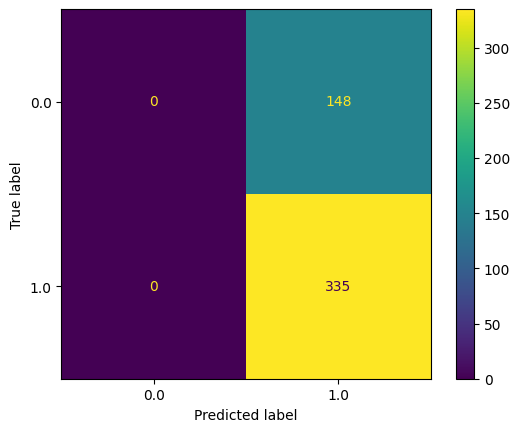

In [75]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb,baseline.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

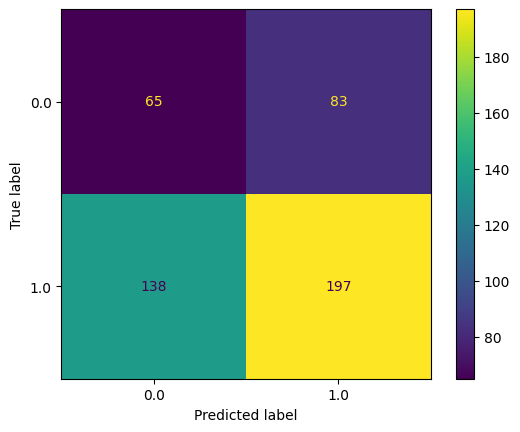

In [76]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_unb, clf.predict(X_test_unb)), display_labels=clf.classes_)
disp.plot()

In [77]:
from sklearn.metrics import classification_report

In [78]:
print(classification_report(y_test_unb, clf.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.32      0.44      0.37       148
         1.0       0.70      0.59      0.64       335

    accuracy                           0.54       483
   macro avg       0.51      0.51      0.51       483
weighted avg       0.59      0.54      0.56       483



In [79]:
print(classification_report(y_test_unb, baseline.predict(X_test_unb)))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       148
         1.0       0.69      1.00      0.82       335

    accuracy                           0.69       483
   macro avg       0.35      0.50      0.41       483
weighted avg       0.48      0.69      0.57       483



c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\envs\jsPsychDev\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
classifier_dict = {
    "Baseline (Chance)": DummyClassifier(strategy="uniform"),
    "Majority": DummyClassifier(strategy="prior"),
    "SVM": make_pipeline(StandardScaler(), SVC(gamma='auto')),
    "Log.Reg": make_pipeline(StandardScaler(), LogisticRegression()),
    "Random Forest": RandomForestClassifier(),
    #"MLPClassifier": MLPClassifier(),
}

In [81]:
classifier_results = {
    "Baseline (Chance)": [],
    "Majority": [],
    "SVM": [],
    "Log.Reg": [],
    "Random Forest": [],
    #"MLPClassifier": [],

}

In [82]:
runs = 10

In [83]:
for i in range(runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
    for clf_name, clf in classifier_dict.items():
        if clf_name == "Majority":
            # Fit data to the original train data
            clf.fit(X_train, y_train)
        else:
            clf.fit(X_train_reb, y_train_reb)
        #print(f"## Results Clf: {clf_name}, seed = {i}")
        preds = clf.predict(X_test)
        acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
        f1_sco = f1_score(y_test, preds, average="weighted")
        f1_sco_macro = f1_score(y_test, preds, average="macro")
        #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
        classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))

In [84]:
print("Results for task: ", TASK_NAME.upper())
print("Is using text features: ", USE_TEXT_FEATURES)
results_df = pd.DataFrame()
for clf_name, results in classifier_results.items():
    results_row = pd.Series()
    print(f"## Results for {clf_name} ##")
    results = np.array(results)
    print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
    print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
    print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
    print()
    results_row[f"Acc (mean $n={runs}$)"] = results[:,0].mean()
    results_row[f"Acc (std $n={runs}$)"] = results[:,0].std()
    results_row[f"F1-Score Weighted (mean n={runs})"] = results[:,1].mean()
    results_row[f"F1-Score Weighted (std n={runs})"] = results[:,1].std()
    results_df[clf_name] = results_row

Results for task:  IS
Is using text features:  False
## Results for Baseline (Chance) ##
Acc: 0.5010 +/- 0.0245
F1-Score (Weighted): 0.5144 +/- 0.0241
F1-Score (Macro): 0.4863 +/- 0.0238

## Results for Majority ##
Acc: 0.6611 +/- 0.0175
F1-Score (Weighted): 0.5263 +/- 0.0223
F1-Score (Macro): 0.3979 +/- 0.0063

## Results for SVM ##
Acc: 0.5994 +/- 0.0235
F1-Score (Weighted): 0.5919 +/- 0.0227
F1-Score (Macro): 0.5370 +/- 0.0206

## Results for Log.Reg ##
Acc: 0.5723 +/- 0.0248
F1-Score (Weighted): 0.5778 +/- 0.0244
F1-Score (Macro): 0.5360 +/- 0.0242

## Results for Random Forest ##
Acc: 0.5623 +/- 0.0168
F1-Score (Weighted): 0.5654 +/- 0.0169
F1-Score (Macro): 0.5182 +/- 0.0174



C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  results_row = pd.Series()
C:\Users\tyagu\AppData\Local\Temp\ipykernel_34312\3798933079.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  re

In [85]:
results_df.T.round(3)

,Acc (mean $n=10$),Acc (std $n=10$),F1-Score Weighted (mean n=10),F1-Score Weighted (std n=10)
Baseline (Chance),0.501,0.024,0.514,0.024
Majority,0.661,0.017,0.526,0.022
SVM,0.599,0.024,0.592,0.023
Log.Reg,0.572,0.025,0.578,0.024
Random Forest,0.562,0.017,0.565,0.017


In [86]:
import warnings

In [87]:
def run_tests_classifier(set_lists=[["EN", "DE", "ES", "TR"]], accuracy_min_list = [0, 20], approved_min_list = [0],
                         list_text_features = [False, True], task_names_list=["nr", "is"]):
    for set_list_selected in set_lists:
        for task_selected in task_names_list:
            for acc_selected in accuracy_min_list:
                for approved_selected in approved_min_list:
                    for text_features_selected in list_text_features:
                        # Filters to apply:
                        approved_only = (data.approved_flag > approved_selected).to_numpy() 
                        no_fixation_error = (data.fixation_error == False).to_numpy()
                        no_target_error = (data.target_error == False).to_numpy()
                        sample_higher_10 = (data.webgazer_sample_rate > 10).to_numpy()
                        acc_higher = (data.avg_roi_last_val > acc_selected).to_numpy()
                        filter_mturks = np.array([False if "link" in worker_id else True for worker_id in data["worker_id"]])
                        filter_sets = np.array([True if set_lang in set_list_selected else False for set_lang in data["set_language"]])
                        # Set a maximum time to 60 minutes
                        # "EN", "DE", "ES", "TR"
                        max_time_min = 60
                        filter_max_time = (data.exp_total_time < max_time_min/0.000016666).to_numpy()

                        screen_x_above_1280 = (data.screen_x > 1110).to_numpy() # Some tolerance
                        screen_y_above_720 = (data.screen_y > 615).to_numpy() # Some Tolerance
                        screen_above_1280_720 = screen_x_above_1280 & screen_y_above_720
                        dict_filter = {
                            #"filter_mturks" : filter_mturks,
                            "filter_sets" : filter_sets,
                            "Approved":approved_only,
                            "Sample Rate": sample_higher_10,
                            "Fix_Error, Target_Error": no_fixation_error & no_target_error,
                            "screen_above_1280_720": screen_above_1280_720,
                            "acc_thresh": acc_higher,
                            f"Maximum time ({max_time_min} min)":filter_max_time
                        }
                        n_total = len(data)
                        current_filter = np.ones(len(data),dtype=bool)
                        for condition, f in dict_filter.items():
                            n_data_filtered = len(data.iloc[~f & current_filter])
                            per_cent = n_data_filtered/n_total * 100
                            print(f"For condition ({condition}), {per_cent:.2f}% has been filtered. ({n_data_filtered} out of {n_total})")
                            current_filter = current_filter & f
                            n_total = len(data.iloc[current_filter])
                        # Combine filters into a mask
                        mask = np.ones(data.shape[0], dtype=bool)
                        for filter_name, filter_mask in dict_filter.items():
                            mask = mask & filter_mask
                        data_filtered = data[mask].copy()
                        print("Before: ", data.shape, " After: ", data_filtered.shape)

                        USE_TEXT_FEATURES = text_features_selected
                        TASK_NAME = task_selected

                        # Get a vector of Text_TRT, Target_TRT, Fix_Target, Fix_Total, Correct_Flag
                        data_for_cls_nr = []
                        data_for_cls_is = []
                        rows_dropped = 0
                        for i in range(10):
                            for row_i, row in data_filtered.iterrows():
                                # Remove rows where there is no fixation on text
                                if row[f"trial_{i}_fixation_text_TRT"] == 0:
                                    assert row[f"trial_{i}_fixation_target_TRT"] == 0
                                    rows_dropped += 1
                                    continue
                                set_lang = row["set_language"] 
                                set_name = row["set_name"]
                                worker_id = row["worker_id"]
                                trial_name = row[f"trial_{i}_name"]
                                target = row[f"question_{i}_name"]
                                
                                text_features_row = text_settings_all_settings[(text_settings_all_settings["lang"] == set_lang)
                                                                                & (text_settings_all_settings["trial_name"] == trial_name)]
                                word_sent_avg = text_features_row["sentence_count"].item()
                                participant_fix_dict = pd.read_csv(os.path.join("pre_processed_data","fixation_data_per_part",f"{worker_id}_{set_name}_fix_dict.csv"))
                                in_span_TRT = []
                                out_span_TRT = []
                                for ir, fix_row in participant_fix_dict[participant_fix_dict.text_id == trial_name].iterrows():
                                    if type(fix_row["Span_word_is_in"]) is str:
                                        if target in fix_row["Span_word_is_in"]:
                                            in_span_TRT.append(fix_row["TRT"])
                                    else:
                                        out_span_TRT.append(fix_row["TRT"])
                                with warnings.catch_warnings():
                                    warnings.simplefilter("ignore", category=RuntimeWarning)
                                    in_span_mean = np.nanmean(np.array(in_span_TRT))
                                    if np.isnan(in_span_mean):
                                        in_span_mean = 0
                                    out_span_mean = np.nanmean(np.array(out_span_TRT))
                                    if np.isnan(out_span_mean):
                                        out_span_mean = 0
                                data_to_append = row[[
                                        f"trial_{i}_fixation_text_TRT", 
                                        f"trial_{i}_fixation_target_TRT", 
                                        f"trial_{i}_fixation_on_target", 
                                        f"question_{i}_target_to_fixation_ratio",
                                        f"trial_{i}_fixation_total",
                                        #f"trial_{i}_time",
                                        f"question_{i}_correct_flag"]].to_numpy()
                                relative_TRT = row[f"trial_{i}_fixation_target_TRT"] / row[f"trial_{i}_fixation_text_TRT"]
                                if USE_TEXT_FEATURES:
                                    data_to_append = np.hstack(( [
                                                            in_span_mean,
                                                            out_span_mean,
                                                            relative_TRT,
                                                            text_features_row["token_count"].item(),
                                                            text_features_row["token_avg_length"].item(), 
                                                            ], 
                                                            data_to_append))
                                else:
                                    data_to_append = np.hstack(( [
                                                                in_span_mean,
                                                                out_span_mean,
                                                                relative_TRT,
                                                                ], 
                                                                data_to_append))
                                # Trials < 5 are Normal Reading
                                if i < 5:
                                    data_for_cls_nr.append(data_to_append)
                                # Trials >= 5 are Information Seaking
                                else:
                                    data_for_cls_is.append(data_to_append)

                        data_for_cls_nr = np.array(data_for_cls_nr)
                        data_for_cls_is = np.array(data_for_cls_is)

                        if TASK_NAME == "nr":
                            data_for_classifier = np.array(data_for_cls_nr,dtype=float)
                        else:
                            data_for_classifier = np.array(data_for_cls_is,dtype=float)

                        X, y = data_for_classifier[:,:-1], data_for_classifier[:, -1]

                        classifier_dict = {
                            "Baseline (Chance)": DummyClassifier(strategy="uniform"),
                            "Majority": DummyClassifier(strategy="prior"),
                            "SVM": make_pipeline(StandardScaler(), SVC(gamma='auto')),
                            "Log.Reg": make_pipeline(StandardScaler(), LogisticRegression()),
                            "Random Forest": RandomForestClassifier(),
                            #"MLPClassifier": MLPClassifier(),
                        }

                        classifier_results = {
                            "Baseline (Chance)": [],
                            "Majority": [],
                            "SVM": [],
                            "Log.Reg": [],
                            "Random Forest": [],
                            #"MLPClassifier": [],

                        }

                        runs = 10
                        for i in range(runs):
                            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
                            X_train_reb, y_train_reb = upscale_dataset(X_train, y_train)
                            for clf_name, clf in classifier_dict.items():
                                if clf_name == "Majority":
                                    # Fit data to the original train data
                                    clf.fit(X_train, y_train)
                                else:
                                    clf.fit(X_train_reb, y_train_reb)
                                #print(f"## Results Clf: {clf_name}, seed = {i}")
                                preds = clf.predict(X_test)
                                acc_score = (y_test == preds).mean()#accuracy_score(y_test, preds, normalize=True)
                                f1_sco = f1_score(y_test, preds, average="weighted")
                                f1_sco_macro = f1_score(y_test, preds, average="macro")
                                #print("Acc Score: ", acc_score , "F1-Score: ", f1_sco)
                                classifier_results[clf_name].append((acc_score,f1_sco, f1_sco_macro))
                                
                        results_df = pd.DataFrame()
                        for clf_name, results in classifier_results.items():
                            results_row = pd.Series(dtype=float)
                            #print(f"## Results for {clf_name} ##")
                            results = np.array(results)
                            #print(f"Acc: {results[:,0].mean():.4f} +/- {results[:,0].std():.4f}")
                            #print(f"F1-Score (Weighted): {results[:,1].mean():.4f} +/- {results[:,1].std():.4f}")
                            #print(f"F1-Score (Macro): {results[:,2].mean():.4f} +/- {results[:,2].std():.4f}")
                            #print()
                            results_row[f"Acc (m n={runs})"] = results[:,0].mean()
                            results_row[f"Acc (s n={runs})"] = results[:,0].std()
                            results_row[f"F1 W (m n={runs})"] = results[:,1].mean()
                            results_row[f"F1 W (s n={runs})"] = results[:,1].std()
                            results_df[clf_name] = results_row
                        print("------------------------------------------------------------------")
                        print("Results for settings: ")
                        print("Sets Selected: ", set_list_selected)
                        print("Accuracy Minimum: ", acc_selected)
                        print("Approved Min: ", approved_selected)
                        print("Results for task: ", TASK_NAME.upper())
                        print("Is using text features: ", USE_TEXT_FEATURES)
                        print(y_train.shape, y_train_reb.shape, y_test.shape)
                        print(results_df.T.round(5))
                        for row_i, row in results_df.T.iterrows():
                            print(f"{row['Acc (m n=10)'].round(2):.2f} ({row['Acc (s n=10)'].round(2):.2f}) & {row['F1 W (m n=10)'].round(2):.2f} ({row['F1 W (s n=10)'].round(2):.2f}) &")
                        print("############################################################")
                        print()

In [88]:
run_tests_classifier(approved_min_list=[0, -1], accuracy_min_list=[0])

For condition (filter_sets), 0.83% has been filtered. (5 out of 605)
For condition (Approved), 29.50% has been filtered. (177 out of 600)
For condition (Sample Rate), 10.87% has been filtered. (46 out of 423)
For condition (Fix_Error, Target_Error), 4.24% has been filtered. (16 out of 377)
For condition (screen_above_1280_720), 0.28% has been filtered. (1 out of 361)
For condition (acc_thresh), 1.11% has been filtered. (4 out of 360)
For condition (Maximum time (60 min)), 0.84% has been filtered. (3 out of 356)
Before:  (605, 197)  After:  (353, 197)


------------------------------------------------------------------
Results for settings: 
Sets Selected:  ['EN', 'DE', 'ES', 'TR']
Accuracy Minimum:  0
Approved Min:  0
Results for task:  NR
Is using text features:  False
(1412,) (1596,) (353,)
                   Acc (m n=10)  Acc (s n=10)  F1 W (m n=10)  F1 W (s n=10)
Baseline (Chance)       0.51586       0.03184        0.51722        0.03192
Majority                0.55326       0.01521        0.39425        0.01784
SVM                     0.55014       0.03446        0.52931        0.03644
Log.Reg                 0.53909       0.02974        0.53571        0.02967
Random Forest           0.53201       0.02194        0.53236        0.02168
0.52 (0.03) & 0.52 (0.03) &
0.55 (0.02) & 0.39 (0.02) &
0.55 (0.03) & 0.53 (0.04) &
0.54 (0.03) & 0.54 (0.03) &
0.53 (0.02) & 0.53 (0.02) &
############################################################

For condition (filter_sets), 0.83% has been filtered. (5 out of 605)
For condition (Approved), 29

In [65]:
run_tests_classifier(set_lists=[["EN"], ["DE"], ["ES"], ["TR"]], approved_min_list=[-1])

For condition (filter_sets), 64.46% has been filtered. (390 out of 605)
For condition (Approved), 0.00% has been filtered. (0 out of 215)
For condition (Sample Rate), 9.77% has been filtered. (21 out of 215)
For condition (Fix_Error, Target_Error), 3.09% has been filtered. (6 out of 194)
For condition (screen_above_1280_720), 0.53% has been filtered. (1 out of 188)
For condition (acc_thresh), 2.14% has been filtered. (4 out of 187)
For condition (Maximum time (60 min)), 0.00% has been filtered. (0 out of 183)
Before:  (605, 197)  After:  (183, 197)
------------------------------------------------------------------
Results for settings: 
Sets Selected:  ['EN']
Accuracy Minimum:  0
Approved Min:  -1
Results for task:  NR
Is using text features:  False
(732,) (740,) (183,)
                   Acc (m n=10)  Acc (s n=10)  F1 W (m n=10)  F1 W (s n=10)
Baseline (Chance)       0.46776       0.03509        0.46767        0.03541
Majority                0.47814       0.02471        0.30973       

In [65]:
run_tests_classifier(approved_min_list=[0], accuracy_min_list=[0])

For condition (filter_sets), 0.81% has been filtered. (5 out of 614)
For condition (Approved), 29.23% has been filtered. (178 out of 609)
For condition (Sample Rate), 10.67% has been filtered. (46 out of 431)
For condition (Fix_Error, Target_Error), 4.16% has been filtered. (16 out of 385)
For condition (screen_above_1280_720), 0.27% has been filtered. (1 out of 369)
For condition (acc_thresh), 1.09% has been filtered. (4 out of 368)
For condition (Maximum time (60 min)), 0.82% has been filtered. (3 out of 364)
Before:  (614, 153)  After:  (361, 153)
------------------------------------------------------------------
Results for settings: 
Sets Selected:  ['EN', 'DE', 'ES', 'TR']
Accuracy Minimum:  0
Approved Min:  0
Results for task:  NR
Is using text features:  False
(1442,) (1650,) (361,)
                   Acc (m n=10)  Acc (s n=10)  F1 W (m n=10)  F1 W (s n=10)
Baseline (Chance)       0.49640       0.03109        0.49851        0.03189
Majority                0.56233       0.02521 